In [72]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Data Exploration

In [164]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "6", "14", "35", "37", "69", "328"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["6"] = b_6
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69

def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    print(df['bus_stop_name'].unique())
    df.head()
    return df

In [165]:
more_52 = pd.read_csv("data/bus_arrivals_52.csv")
more_52.loc[more_52['arrived'] == 1, 'arrived'] = True
more_52 = more_52[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
data["52"] = data["52"].append(more_52, ignore_index = True) 

In [166]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (22860, 6)
["Ladbroke Grove Sainsbury's" 'Silverthorne Road'
 'Knightsbridge Station  / Harrods' 'Prince Of Wales Gate' 'Ladbroke Road'
 'Notting Hill Gate Station' 'Pont Street' 'Knightsbridge Station'
 'Kensington Church Street / Holland St' 'Vauxhall Bus Station'
 'Battersea Park Station' 'Cedars Road' 'Kilburn Lane / Harrow Road'
 'Kensal House' 'Ladbroke Grove Station' "Queen's Gate" 'Sopwith Way'
 'Queenstown Road / Wandsworth Road' 'Sheffield Terrace' 'Chesterton Road'
 'Union Road' 'The Chase' 'Kensal Rise Station'
 'Sloane Street / Knightsbridge Station' 'Battersea Park / Chelsea Gate'
 'Royal Albert Hall' 'Wandsworth Road Station' 'Rutland Gardens'
 'Queenstown Road Station' 'Royal Hospital Road' 'Knightsbridge Barracks'
 'Barlby Road' 'Prairie Street' 'Covent Garden Market East Side'
 'Larkhall Park' 'Lister Hospital' 'Harrow Road / Kilburn Lane'
 'Banister Road' 'Stanley Gardens' 'Palace Gate' 'St Charles Square'
 'Lansdowne Green' 'Sloane Square Stn

In [167]:
def spread_of_time(df, route):
    hour_min = [x[11:15] + '0' for x in df['expected_arrival']]
    for_aggr = df.assign(hour_min = hour_min)
    for_aggr = for_aggr.groupby('hour_min').count().reset_index()

    arrival_times = [dt.datetime.strptime(time, '%H:%M') for time in for_aggr['hour_min']]

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(arrival_times, for_aggr['bus_stop_name'])
    ax.set_title("Spread of time of data collected for bus route {}".format(route))
    ax.set_xlim(dt.datetime.strptime('00:00', '%H:%M'), dt.datetime.strptime('23:59', '%H:%M'))
    date_form = DateFormatter("%H-%M")
    ax.xaxis.set_major_formatter(date_form)
    ax.set_xlabel("Time of day")
    ax.set_ylabel("Occurences")
    plt.show()

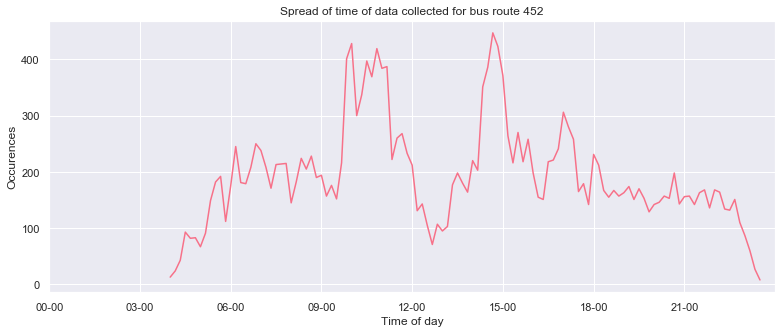

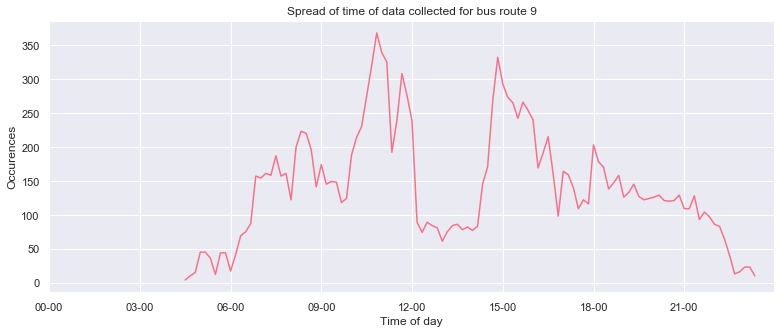

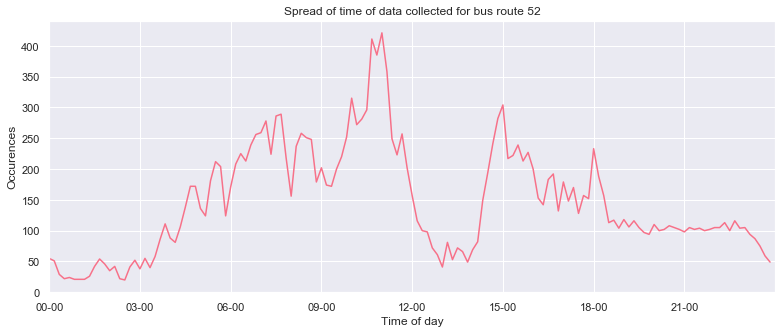

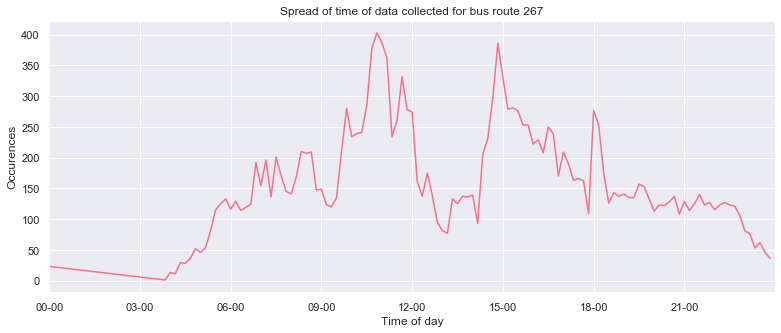

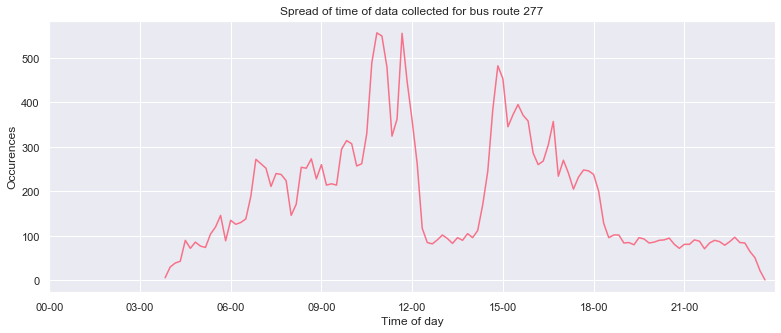

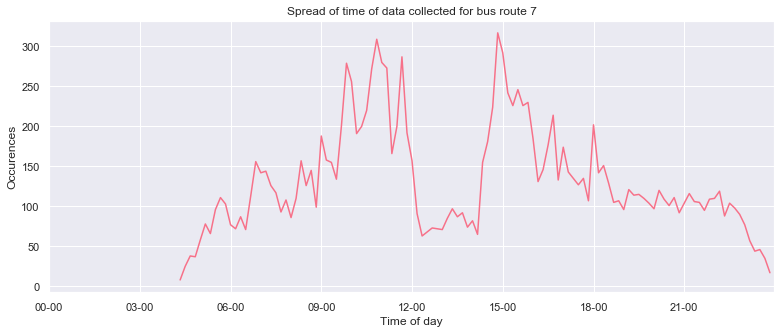

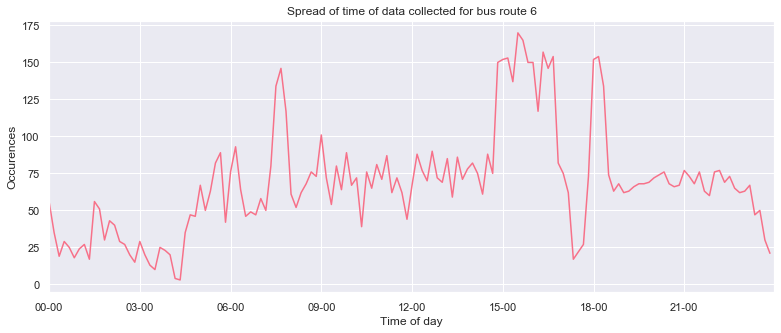

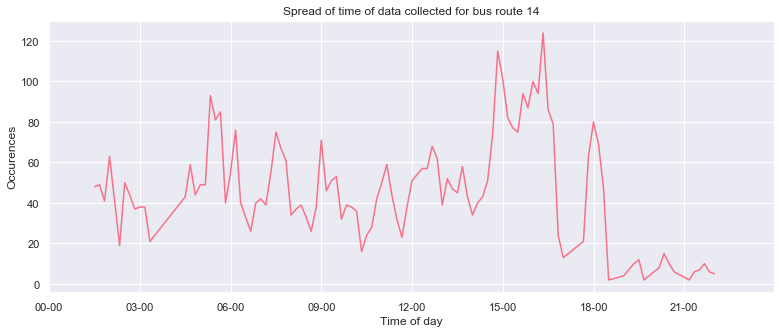

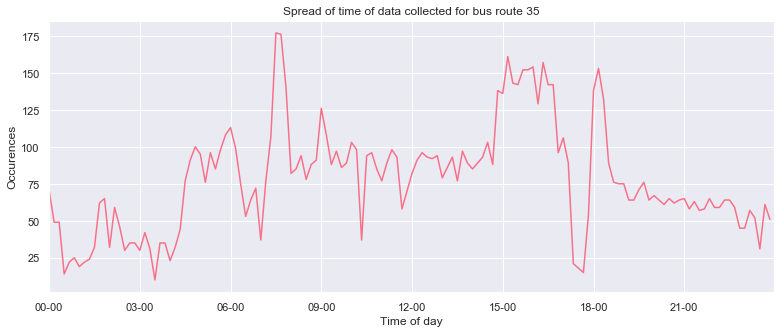

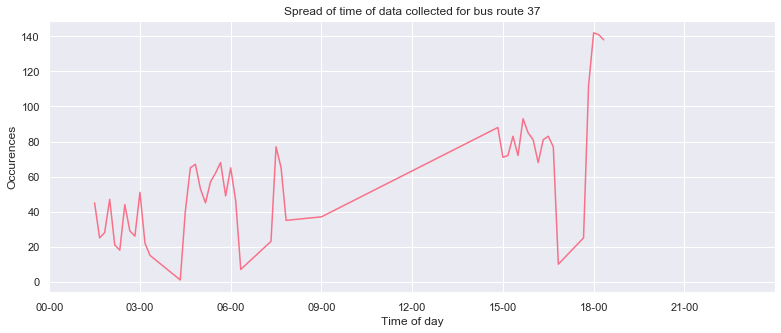

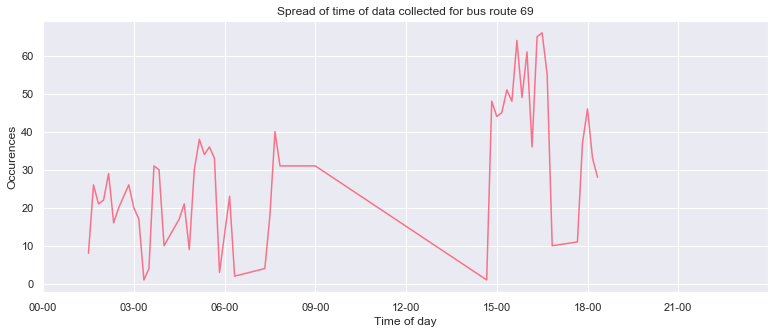

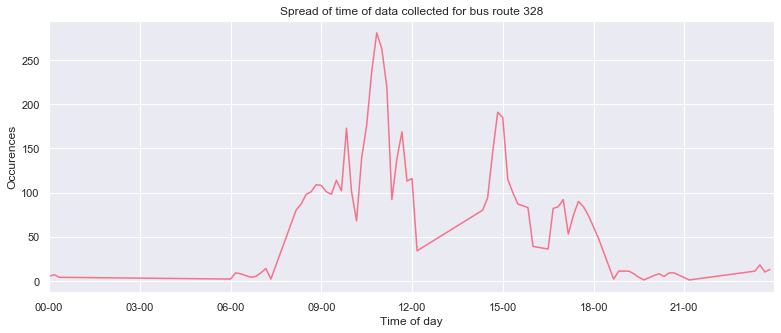

In [168]:
for route in routes:
    spread_of_time(data[route], route)

In [169]:
def spread_of_day_of_week(df, route):

    day_of_week = [x[:10] for x in df['expected_arrival']]
    day_of_week = [dt.datetime.strptime(date, '%Y-%m-%d') for date in day_of_week]

    day_of_week = [calendar.day_name[date.weekday()] for date in day_of_week]
    for_aggr = df.assign(day_of_week = day_of_week)
    for_aggr = for_aggr.groupby('day_of_week').count().reset_index()

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(for_aggr['day_of_week'], for_aggr['bus_stop_name'])
    ax.set_title("Spread of days of the week for data collected for route {}".format(route))
    ax.set_ylim(0)
    ax.set_xlabel("Day of Week")
    ax.set_ylabel("Occurences")
    plt.show()

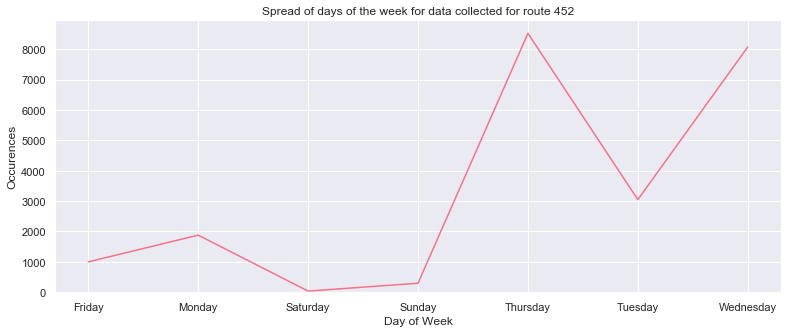

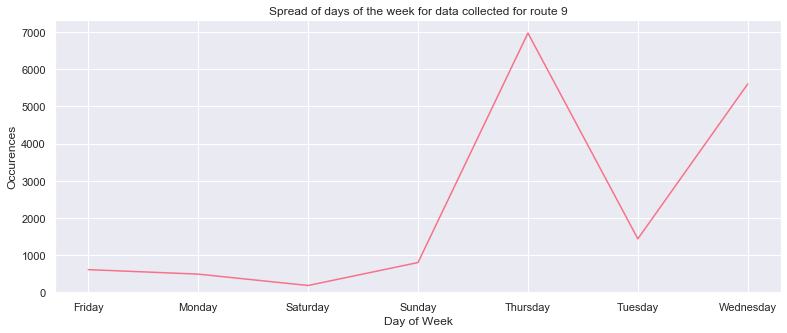

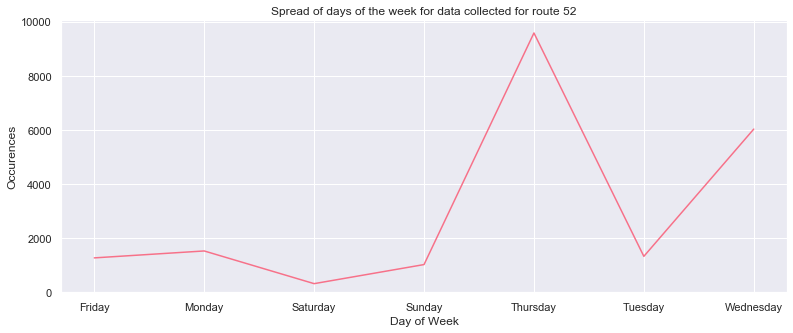

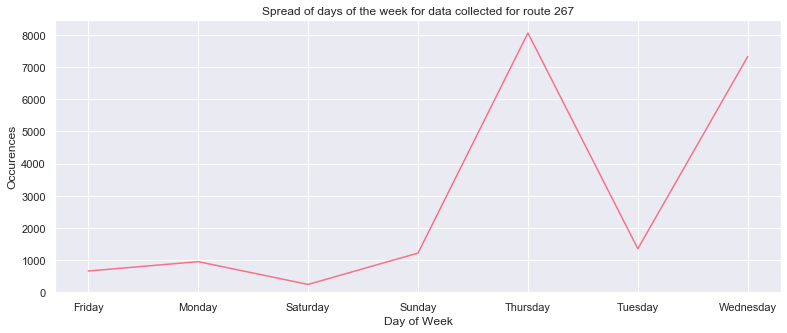

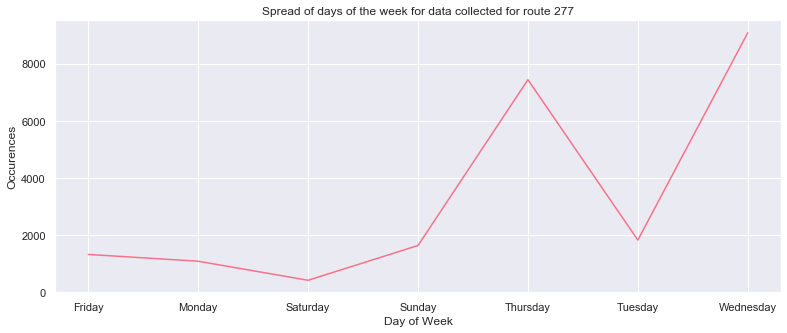

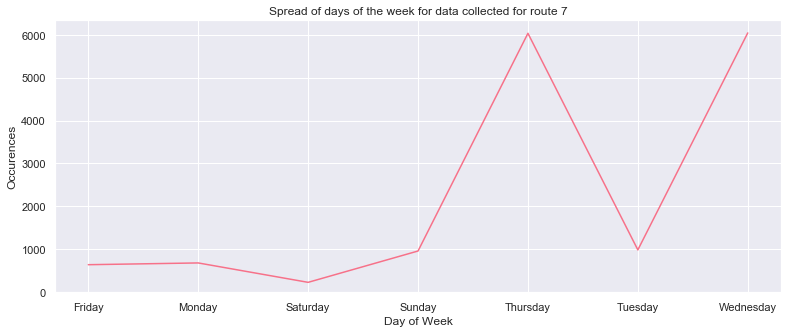

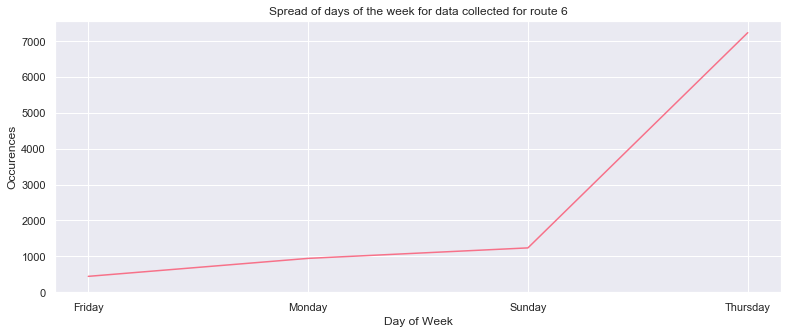

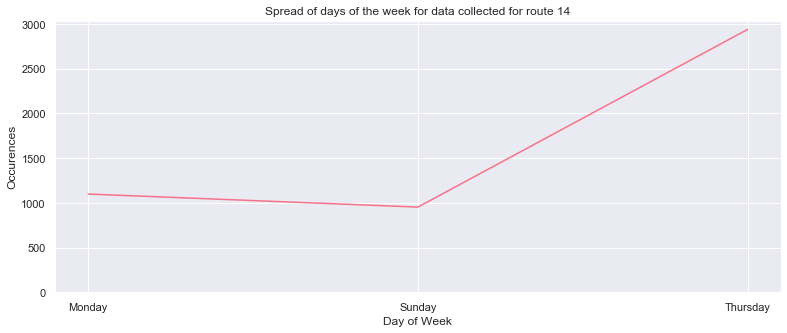

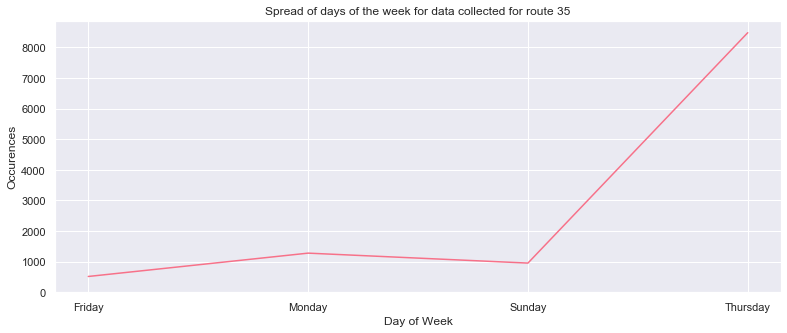

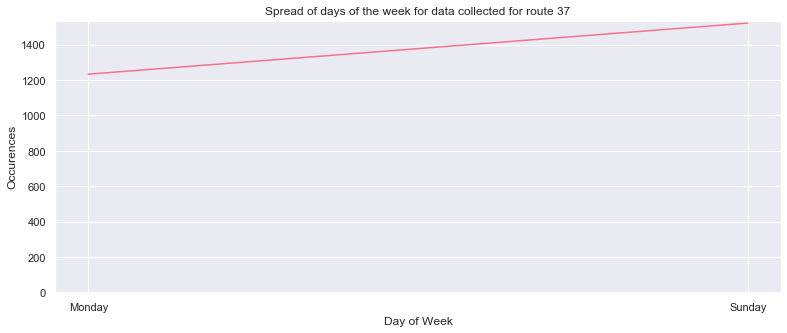

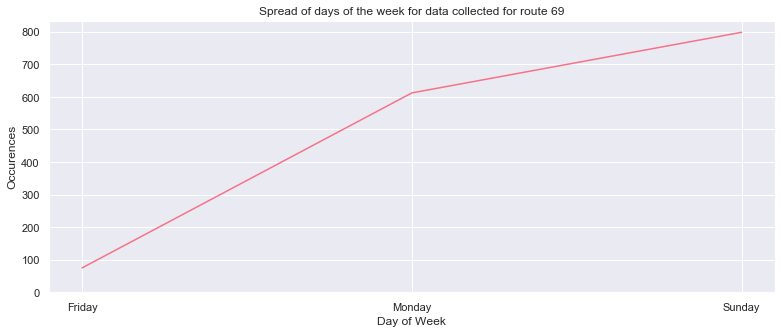

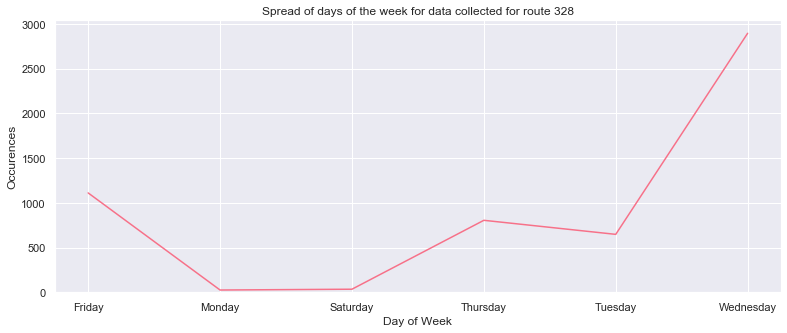

In [170]:
for route in routes:
    spread_of_day_of_week(data[route], route)

# Data Analytics

## Helper Functions

In [171]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time
    
def get_time_of_day_group(given_time):
    hour = int(given_time[11:13])
    if (hour < 3) & (hour >= 0):
        return 0
    elif (hour < 6) & (hour >= 3):
        return 1
    elif (hour < 9) & (hour >= 6):
        return 2
    elif (hour < 12) & (hour >= 9):
        return 3
    elif (hour < 15) & (hour >= 12):
        return 4
    elif (hour < 18) & (hour >= 15):
        return 5
    elif (hour < 21) & (hour >= 18):
        return 6
    elif hour >= 21:
        return 7
    
colour_to_time_label = ["00-03", "03-06", "06-09", "09-12", "12-15", "15-18", "18-21", "21-00"]
cs = [colours[i] for i in range(len(colours))]

In [172]:
def get_times_between_two_stops(stop_a, stop_b, b_id):
    
    """
    journey_times 
        - is a list of all journey times for a bus from stop a to stop b
    time_of_day_grouped 
        - is a list of lists where each sublist represents a time period of the day
        - each sublist contains the journey times for a bus for that time period
    labels
        - is a list of all colour codes for every journey from stop a to stop b
        - e.g. [1,3,2] represents 3 journeys, where the 1st journey was in the time period 03-06
    """

    journey_times = []
    time_of_day_grouped = [[] for i in range (0, 8)]
    labels = []

    a = time.time()
    for i, journey in stop_a.iterrows():
        [bus_id, stop_id, date, direction, num_trip] = journey['vehicle_id'].split('_')
        match_id = bus_id + '_' + b_id + '_' + date + '_' + direction + '_'
        start = convert_time_to_datetime(journey['expected_arrival'])
        for j, match in stop_b.iterrows():
            [bus_idx, stop_idx, datex, directionx, num_tripx] = match['vehicle_id'].split('_')
            end = convert_time_to_datetime(match['expected_arrival'])
            if match['vehicle_id'].startswith(match_id):
                # Error in some of the data where trip num doesn't match so need to check that the travel time
                # is within a reasonable time period
                if (end - start < dt.timedelta(hours = 1)) & (end - start > dt.timedelta(minutes = 0)):
                    diff = end - start
                    journey_times.append(diff)
                    section_of_day = get_time_of_day_group(match['expected_arrival'])
                    labels.append(section_of_day)
                    flt = diff.total_seconds() / 60
                    time_of_day_grouped[section_of_day].append(flt)
                    break

    print("Time taken: ", (time.time() - a))
    for i, group in enumerate(time_of_day_grouped):
        if len(group) == 0:
            time_of_day_grouped[i].append(np.nan)
    
    return journey_times, time_of_day_grouped, labels

In [173]:
def calc_info_for_graphs(journey_times):
    """
    travel_times 
        - is a list of all journey times for a bus from stop a to stop b converted into minutes
    avg_time
        - is the average amount of time for a journey from stop a to stop b across all time periods (minutes)
    counts
        - is a list of the number of times each journey time occurs
        - e.g. a journey time of 16 minutes may occur 2 times.
    """
    
    travel_times = [(time.total_seconds() / 60) for time in journey_times]
    avg_time = sum(travel_times) / len(travel_times)
    counts = [journey_times.count(elem) for elem in journey_times]
    return travel_times, avg_time, counts

In [174]:
def graph_travel_times(travel_times, avg_time, counts, stop_a, stop_b, route):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.scatter(travel_times, counts)
    ax.axvline(x = avg_time, linestyle='dashed', label = "average travel time")
    ax.set_xlabel("Travel Time (minute)")
    ax.set_ylabel("Occurences")
    ax.set_ylim(0)
    ax.set_title("Graph showing the travel time of bus {} from {} to {}".format(route, stop_a, stop_b))
    ax.legend()
    plt.show()

In [175]:
def graph_travel_by_time_of_day(route, stop_a, stop_b, travel_times, counts, labels):
    fig, ax = plt.subplots(figsize=(15,6))
    sctr = ax.scatter(travel_times, counts, c=labels, cmap=matplotlib.colors.ListedColormap(cs))
    ax.axvline(x = avg_time, linestyle='dashed', label = "average travel time")
    ax.set_xlabel("Travel Time (minute)")
    ax.set_ylabel("Occurences")
    ax.set_ylim(0)
    ax.set_title("Graph showing the travel time of bus {} from {} to {} grouped by time of day of travel".format(route, stop_a, stop_b))
    ax.legend()

    # Can't get ticks to show properly on the colour bar maybe because there is no data for 00-03?
    cbar = fig.colorbar(sctr)
    cbar.set_ticks([0, 1, 2, 3, 4, 5, 6, 7])
    cbar.set_ticklabels(colour_to_time_label)
    cbar.ax.set_title("Time of day")

    plt.show()

In [176]:
def graph_travel_by_time_of_day_2(time_of_day_grouped, avg_time, route, stop_a, stop_b):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Travel Time (minutes)")

    for x, y in zip(colour_to_time_label, time_of_day_grouped):
        ax.scatter([x] * len(y), y)

    ax.plot(colour_to_time_label, [avg_time] * len(colour_to_time_label), 'k--', label='average time')
    ax.set_xticklabels(colour_to_time_label)
    ax.legend()
    ax.set_title("Graph showing the travel time of bus {} from {} to {} grouped by time of day of travel".format(route, stop_a, stop_b))
    plt.show()

## Historical Average Models

### Try to see if I can get the average time taken for a bus to travel between "Vauxhall Bus Station" and "Battersea Park Station" (inbound) for bus 452

In [177]:
b_452 = data["452"]
vauxhall = b_452.loc[(b_452['bus_stop_name'] == 'Vauxhall Bus Station') & (b_452['direction'] == 'in')]
[_, vauxhall_id, _, _, _] = vauxhall.iloc[0]['vehicle_id'].split('_')
print(vauxhall.shape)
print(vauxhall_id)
vauxhall.head()

(249, 5)
490000247G1


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
11,Vauxhall Bus Station,2020-04-02 17:07:31,20189_490000247G1_2020-04-02_in_2,2020-04-02 16:49:18,in
48,Vauxhall Bus Station,2020-03-30 05:52:51,20191_490000247G1_2020-03-30_in_0,2020-03-30 05:28:43,in
76,Vauxhall Bus Station,2020-03-30 07:11:46,20310_490000247G1_2020-03-30_in_0,2020-03-30 06:43:43,in
151,Vauxhall Bus Station,2020-04-02 22:51:27,20199_490000247G1_2020-04-02_in_8,2020-04-02 22:51:37,in
292,Vauxhall Bus Station,2020-04-02 22:39:01,20278_490000247G1_2020-04-02_in_7,2020-04-02 22:36:37,in


In [110]:
battersea_prk_st = b_452.loc[(b_452['bus_stop_name'] == 'Battersea Park Station') & (b_452['direction'] == 'in')]
[_, battersea_prk_st_id, _, _, _] = battersea_prk_st.iloc[0]['vehicle_id'].split('_')
print(battersea_prk_st.shape)
print(battersea_prk_st_id)
battersea_prk_st.head()

(259, 5)
490G01016A


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
12,Battersea Park Station,2020-04-02 13:18:42,20189_490G01016A_2020-04-02_in_0,2020-04-02 13:16:44,in
13,Battersea Park Station,2020-04-01 10:27:00,20271_490G01016A_2020-04-01_in_0,2020-04-01 10:26:42,in
34,Battersea Park Station,2020-04-01 09:53:39,20196_490G01016A_2020-04-01_in_0,2020-04-01 09:53:03,in
37,Battersea Park Station,2020-04-06 07:36:56,20314_490G01016A_2020-04-06_in_1,2020-04-06 07:27:02,in
84,Battersea Park Station,2020-04-02 05:41:12,20193_490G01016A_2020-04-02_in_0,2020-04-02 05:34:44,in


In [111]:
journey_times_bv452, time_of_day_grouped_bv452, labels_bv452 = get_times_between_two_stops(battersea_prk_st, vauxhall, vauxhall_id)
travel_times_bv452, avg_time_bv452, counts_bv452 = calc_info_for_graphs(journey_times_bv452)
print("Average travel time between Vauxhall Bus Station and Battersea Park Station is {} minutes".format(avg_time_bv452))

Time taken:  4.622063159942627
Average travel time between Vauxhall Bus Station and Battersea Park Station is 14.576501501501513 minutes


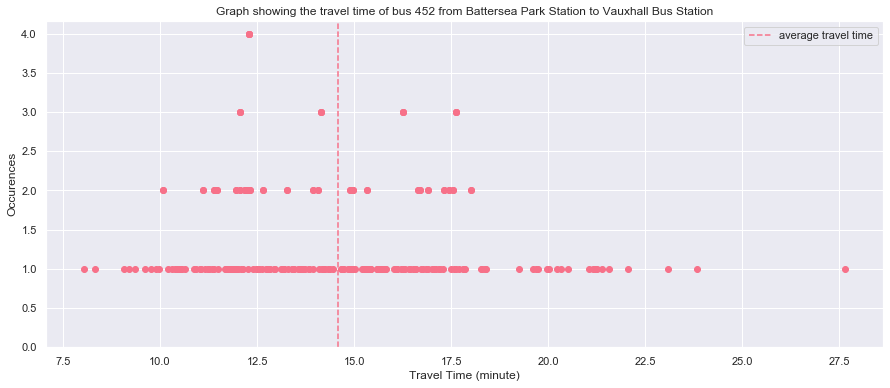

In [112]:
graph_travel_times(travel_times_bv452, avg_time_bv452, counts_bv452, "Battersea Park Station", "Vauxhall Bus Station", "452")

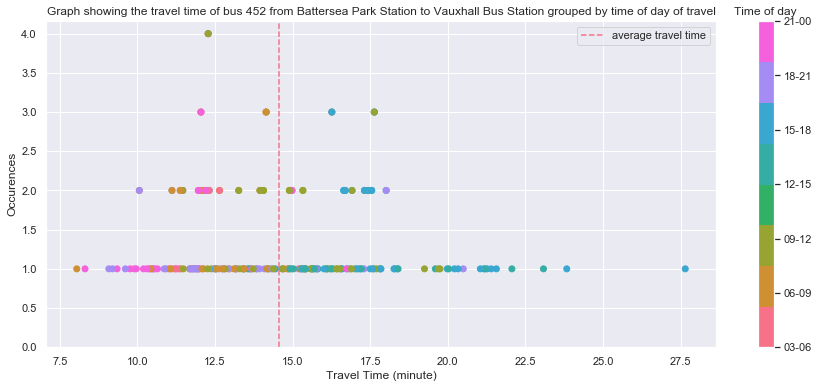

In [113]:
# labels for colour bar don't match because there is no information for 00-03
graph_travel_by_time_of_day("452", "Battersea Park Station", "Vauxhall Bus Station", travel_times_bv452, counts_bv452, labels_bv452)

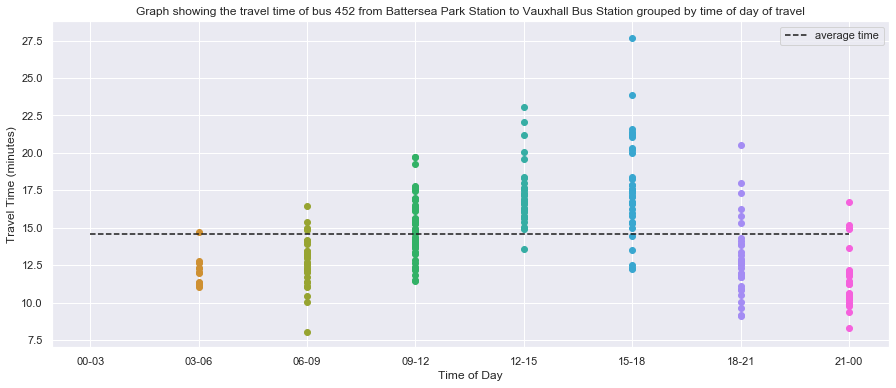

In [117]:
graph_travel_by_time_of_day_2(time_of_day_grouped_bv452, avg_time_bv452, "452", "Battersea Park Station", "Vauxhall Bus Station")

### Try to see if I can get the average time taken for a bus to travel from "All Souls Avenue" to "Nottinghill Gate Station" (outbound) for bus 52

In [178]:
b_52 = data["52"]
ntg_stn = b_52.loc[(b_52['bus_stop_name'] == 'Notting Hill Gate Station') & (b_52['direction'] == 'out')]
[_, ntg_stn_id, _, _, _] = ntg_stn.iloc[0]['vehicle_id'].split('_')
print(ntg_stn.shape)
print(ntg_stn_id)
ntg_stn.head()

(314, 5)
490000167G


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
106,Notting Hill Gate Station,2020-03-11 10:51:36,10805_490000167G_2020-03-11_out_0,2020-03-11 10:51:46,out
222,Notting Hill Gate Station,2020-04-01 20:38:13,11741_490000167G_2020-04-01_out_2,2020-04-01 20:33:12,out
310,Notting Hill Gate Station,2020-04-05 15:45:34,10627_490000167G_2020-04-05_out_0,2020-04-05 15:41:18,out
385,Notting Hill Gate Station,2020-04-02 10:17:57,19407_490000167G_2020-04-02_out_3,2020-04-02 09:55:17,out
495,Notting Hill Gate Station,2020-04-01 11:46:02,10509_490000167G_2020-04-01_out_0,2020-04-01 11:36:42,out


In [179]:
all_souls_avn = b_52.loc[(b_52['bus_stop_name'] == 'All Souls Avenue') & (b_52['direction'] == 'out')]
[_, all_souls_avn_id, _, _, _] = all_souls_avn.iloc[0]['vehicle_id'].split('_')
print(all_souls_avn.shape)
print(all_souls_avn_id)
all_souls_avn.head()

(305, 5)
490003256N


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
6,All Souls Avenue,2020-04-05 16:04:21,10292_490003256N_2020-04-05_out_0,2020-04-05 16:02:45,out
70,All Souls Avenue,2020-04-02 19:46:21,11741_490003256N_2020-04-02_out_2,2020-04-02 19:46:08,out
75,All Souls Avenue,2020-04-02 08:19:56,19643_490003256N_2020-04-02_out_2,2020-04-02 08:16:45,out
104,All Souls Avenue,2020-04-06 05:22:11,11473_490003256N_2020-04-06_out_0,2020-04-06 05:20:17,out
128,All Souls Avenue,2020-03-27 08:31:28,19667_490003256N_2020-03-27_out_0,2020-03-27 08:11:14,out


In [184]:
journey_times_na52, time_of_day_grouped_na52, labels_na52 = get_times_between_two_stops(all_souls_avn, ntg_stn, ntg_stn_id)
travel_times_na52, avg_time_na52, counts_na52 = calc_info_for_graphs(journey_times_na52)
print("Average travel time between Nottinghill Gate Station and All Souls Avenue is {} minutes".format(avg_time_na52))

Time taken:  6.833863973617554
Average travel time between Nottinghill Gate Station and All Souls Avenue is 15.964599483204134 minutes


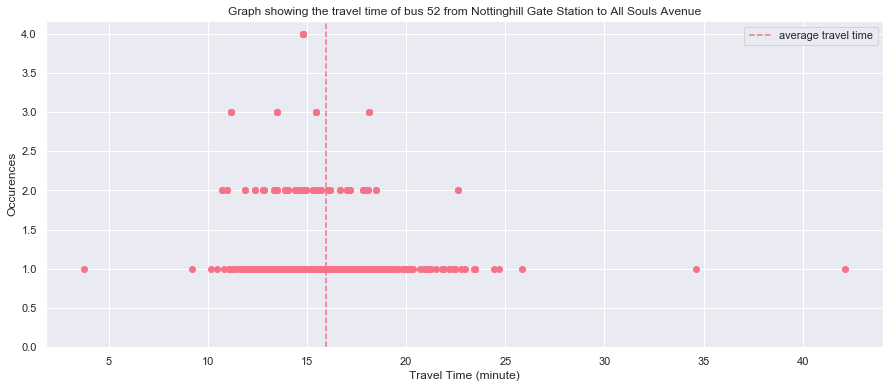

In [185]:
graph_travel_times(travel_times_na52, avg_time_na52, counts_na52, "Nottinghill Gate Station", "All Souls Avenue", "52")

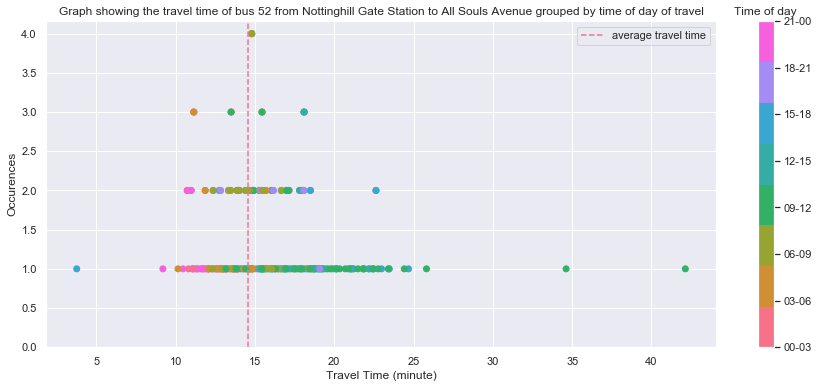

In [186]:
graph_travel_by_time_of_day("52", "Nottinghill Gate Station", "All Souls Avenue", travel_times_na52, counts_na52, labels_na52)

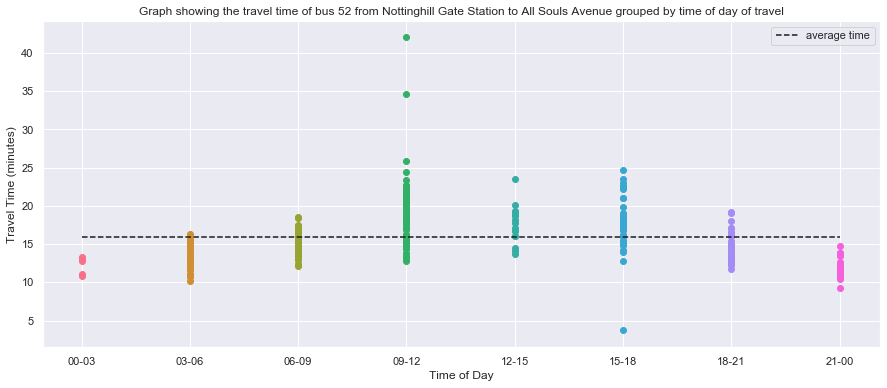

In [187]:
graph_travel_by_time_of_day_2(time_of_day_grouped_na52, avg_time_na52, "52", "Nottinghill Gate Station", "All Souls Avenue")

### Try a simple naive seasonal model -> To get the predicted travel time and thus arrival time of a bus, we get the average of the historical travel times for the time period we are in now

If a bus left All Souls Avenue at time X, what time would it arrive at Nottinghill Gate Station?

In [188]:
from sklearn.model_selection import train_test_split

x_train = [[] for i in range (0, 8)]
x_test = [[] for i in range (0, 8)]
y_train = [[] for i in range (0, 8)]
y_test = [[] for i in range (0, 8)]

for i in range(0, 8):
    y = [colour_to_time_label[i] for j in range(0, len(time_of_day_grouped_na52[i]))]
    x_tr, x_te, y_tr, y_te = train_test_split(time_of_day_grouped_na52[i], y, test_size=0.3)
    x_train[i] = x_tr
    x_test[i] = x_te
    y_train[i] = y_tr
    y_test[i] = y_te
    
print(x_train[4])
print(x_test[4])

[23.466666666666665, 19.0, 19.25, 14.116666666666667, 16.833333333333332, 20.05, 18.1, 16.666666666666668, 13.65, 19.266666666666666, 18.95, 16.983333333333334]
[16.1, 17.816666666666666, 18.616666666666667, 14.55, 16.05, 17.15]


In [189]:
from sklearn.metrics import mean_squared_error

#If a bus left All Souls Avenue at 12.51.36, what time would it arrive at Nottinghill Gate Station?
leaving_time = "2020-04-12 12:51:36"
group = get_time_of_day_group(leaving_time)
hist = x_train[group]
pred = sum(hist) / len(hist)
pred_list = [pred for i in range(0, len(x_test[group]))]

mse = mean_squared_error(x_test[group], pred_list)

print("A bus left All Souls Avenue at {}".format(leaving_time))
print("Its predicted journey time is {}".format(pred))
print("The Mean Squared Error is {}".format(mse))

A bus left All Souls Avenue at 2020-04-12 12:51:36
Its predicted journey time is 18.027777777777775
The Mean Squared Error is 3.4807870370370284


### Try a simple naive seasonal model -> We can plot the travel times of the training data then draw a line of best fit (i.e. form a linear regression model). Use this line of best fit to predict the travel time and then do the same for the test data and see error and accuracy?

If a bus left All Souls Avenue at time X, what time would it arrive at Nottinghill Gate Station?

[233.  91. 111. 152. 120.  67. 310.  94. 183.  66. 173.  72.  49.  64.
  48. 178. 104. 132. 220.  57.]
Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


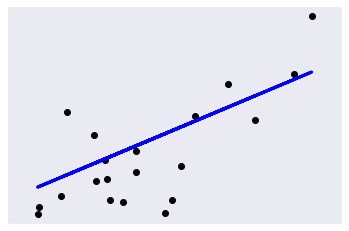

In [137]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

print(diabetes_y_test)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()